# Bifurcation diagram with MPI

In [13]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

Logistic map:

$$x_{n+1} = r \cdot x_{n} \cdot (1 - x_{n})$$


In [3]:
def logistic_map(r, x):
    return r * x * (1 - x)

## Evolution of x

In [3]:
def plot_the_evolution(r, num_steps):
    x = np.random.uniform(size=num_steps)

    for step in range(num_steps - 1):
        x[step + 1] = logistic_map(r, x[step])

    plt.figure(figsize=(10, 3))
    plt.plot(x, label='r = {}'.format(r))

    plt.title('The evolution of x')
    plt.legend()
    plt.xlabel('step')
    plt.ylabel('x')


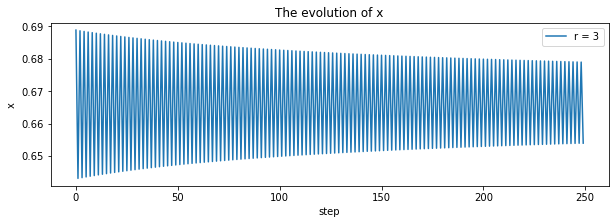

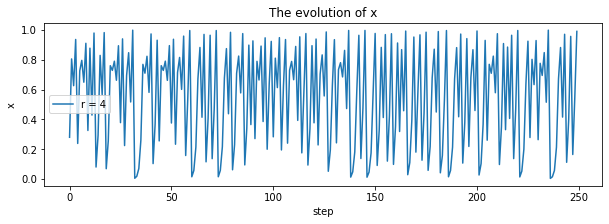

In [4]:
plot_the_evolution(r=3, num_steps=250)
plot_the_evolution(r=4, num_steps=250)

## Get the bifurcation map and visualize the evolution

### Default

In [5]:
def plot_bifurcation_map(n: int, m: int, r: npt.NDArray[np.float64]) -> None:
    history = np.zeros((m, len(r)))
    x = np.random.uniform(size=len(r))
    
    for _ in range(n):
        x = logistic_map(r, x)
    for i in range(m):
        x = logistic_map(r, x)
        history[i] = x

    plt.figure(figsize=(15, 5))
    plt.plot(r, history.T, 'k.', markersize=0.15)
    
    plt.title('Bifurcation map, n={}, m={}'.format(n, m))
    plt.xlabel('r')
    plt.ylabel('x')

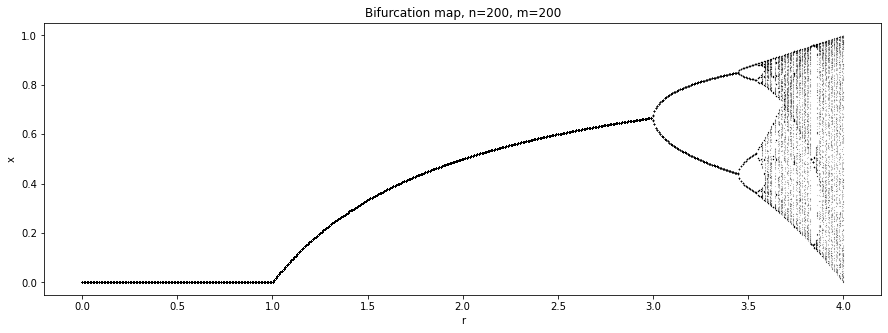

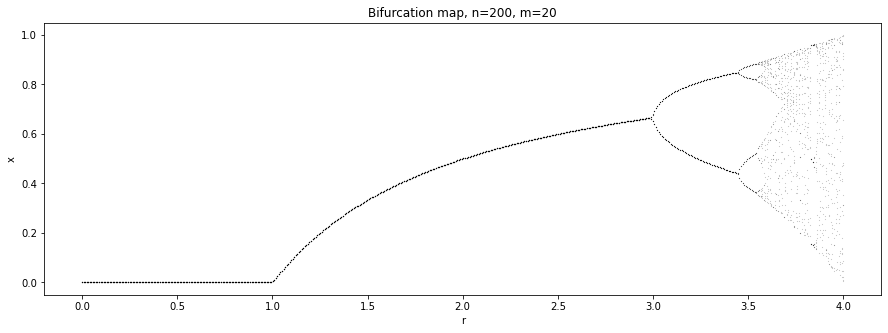

In [6]:
r_linspace = np.linspace(0, 4, num=500)
plot_bifurcation_map(200, 200, r_linspace)
plot_bifurcation_map(200, 20, r_linspace)

### With MPI

In [46]:
%%writefile task_05_bm_map_mpi.py

import time
import numpy as np
import matplotlib.pyplot as plt

from mpi4py import MPI


def logistic_map(r, x):
    return r * x * (1 - x)


comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

linspace_size = 1_000_000
n = 200
m = 200

r = np.linspace(0, 4, linspace_size, dtype=float)
calc_size = linspace_size // size

if rank == 0:
    start = time.time()
    history = np.zeros(linspace_size * m, dtype=float)
else:
    history = None

rank_r = r[calc_size * rank:calc_size * rank + calc_size]
if rank == (size - 1):
    rank_r = r[calc_size * rank:]


x = np.random.uniform(size=len(rank_r))
ans = np.empty((m , len(rank_r)), dtype=float)
for _ in range(n):
    x = logistic_map(rank_r, x)
for i in range(m):
    x = logistic_map(rank_r, x)
    ans[i] = x
ans = ans.T.reshape(-1)

sendcounts = np.array(comm.gather(len(ans), 0))

comm.Gatherv(sendbuf=ans, recvbuf=(history, sendcounts), root=0)

if rank == 0:
    history = history.reshape((linspace_size, m))
    print('Time: {:.3f}s'.format(time.time() - start))
    
    # plt.figure(figsize=(15, 5))
    # plt.plot(r, history, 'k.', markersize=0.15)

    # plt.title('Bifurcation map, n={}, m={}'.format(n, m))
    # plt.xlabel('r')
    # plt.ylabel('x')
    # plt.show()

Overwriting task_05_bm_map_mpi.py


#### MPI run

Time of work:
- 1 process: 10.661s
- 2 processes: 4.146s
- 3 processes: 2.344s